In [1]:
# Regular packages
import pandas as pd
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings("ignore") # might not be the best idea

In [2]:
# pyspark packages 
from pyspark.sql.functions import col, concat, collect_list,struct
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
from pyspark.sql.functions import udf, array, array_distinct, array_min,array_max,array_union, explode
from pyspark.sql.types import IntegerType, DoubleType, ArrayType

from pyspark import SparkContext
from pyspark.sql import Row

## Analysis of RDD 

In [3]:
def file_to_rdd(file):
    """
    This function takes a file name and converts it into an RDD.
    
    Arguments:
    file (str): file name
    
    Returns:
    An RDD containing all information extracted from the file.
    """

    if file[-3:] == "csv" : 
        data = spark.read.format("csv").option("inferSchema", "true")\
                                        .option("delimiter", ',')\
                                        .option("header", 'true')\
                                        .load(file).cache()

        rdd = adj_cache.rdd.map(tuple)
        return rdd
    elif file[-3:] == "txt" : 
        rdd_web = sc.textFile(file) \
                    .map(lambda line: line.split('\t')) \
                    .filter(lambda line: len(line)>1) \
                        .map(lambda line: (line[0],line[1]))

        return rdd_web

In [4]:
sc = SparkContext()

In [5]:
spark = SparkSession.builder.appName('abc').getOrCreate()

In [6]:
#First try with the example of the research paper 

from pyspark import SparkContext

time1 = time.time()

graph = sc.parallelize([(0, 1), (1, 2), (1, 3), (3, 4), (5, 6), (6, 7)])
counter_new_pair = sc.accumulator(1)

def reducer(node):
    minimum = node[0]
    value_List = []
    joined = []
  
    for value in node[1]:
        if value<minimum:
            minimum = value
        value_List.append(value)
    if minimum<node[0]:
        joined.append((node[0],minimum))
        for value in value_List:
            if minimum != value:
                counter_new_pair.add(1)
                joined.append((value, minimum))
    return joined

while counter_new_pair.value > 0:
    counter_new_pair = sc.accumulator(0)

    #CCF-Iterate
    mapping_1 = graph.map(lambda node : (node[0], node[1]))
    mapping_2 = graph.map(lambda node : (node[1], node[0]))
    fusion = mapping_1.union(mapping_2)
    fusion = fusion.groupByKey().map(lambda node : (node[0], list(node[1])))
    joined = fusion.flatMap(lambda node: reducer(node))
    # CCF-Dedup
    graph = joined.map(lambda node : ((node[0], node[1]), None)).groupByKey()
    graph = graph.map(lambda x: (x[0][0], x[0][1]))
    graph.collect()
  
    print("counter: ", counter_new_pair)
  
    graph.collect()
    
time2 = time.time()

print("It took {:.3f} seconds".format(time2-time1))

counter:  4
counter:  9
counter:  4
counter:  0
It took 8.229 seconds


In [7]:
#Let's try with the Google Graph 

web_google = sc.textFile("web-Google 2.txt")\
                    .map(lambda line: line.split('\t')) \
                    .filter(lambda line: len(line)>1) \
                        .map(lambda line: (line[0],line[1]))

graph = web_google

time1 = time.time()

counter_new_pair = sc.accumulator(1)

def reducer(node):
    minimum = node[0]
    value_List = []
    joined = []
  
    for value in node[1]:
        if value<minimum:
            minimum = value
        value_List.append(value)
    if minimum<node[0]:
        joined.append((node[0],minimum))
        for value in value_List:
            if minimum != value:
                counter_new_pair.add(1)
                joined.append((value, minimum))
    return joined

while counter_new_pair.value > 0:
    counter_new_pair = sc.accumulator(0)

    #CCF-Iterate
    mapping_1 = graph.map(lambda node : (node[0], node[1]))
    mapping_2 = graph.map(lambda node : (node[1], node[0]))
    fusion = mapping_1.union(mapping_2)
    fusion = fusion.groupByKey().map(lambda node : (node[0], list(node[1])))
    joined = fusion.flatMap(lambda node: reducer(node))
    # CCF-Dedup
    graph = joined.map(lambda node : ((node[0], node[1]), None)).groupByKey()
    graph = graph.map(lambda x: (x[0][0], x[0][1]))
    graph.collect()
  
    print("counter: ", counter_new_pair)
    
time2 = time.time()

print("It took {:.3f} seconds".format(time2-time1))

counter:  8546673
counter:  4774134
counter:  3235857
counter:  3852842
counter:  2014247
counter:  94614
counter:  1548
counter:  0
It took 177.622 seconds


In [11]:
# Comparison according to graph size 

values = [len(web_google.collect())//(10-i) for i in range(1, 10)]

time_ = []

for i in range(len(values)):
    graph = sc.parallelize(web_google.collect()[1:values[i]])
    
    time1 = time.time()
    
    counter_new_pair = sc.accumulator(1)
    
    while counter_new_pair.value > 0:
        
        counter_new_pair = sc.accumulator(0)

        #CCF-Iterate
        mapping_1 = graph.map(lambda node : (node[0], node[1]))
        mapping_2 = graph.map(lambda node : (node[1], node[0]))
        fusion = mapping_1.union(mapping_2)
        fusion = fusion.groupByKey().map(lambda node : (node[0], list(node[1])))
        joined = fusion.flatMap(lambda node: reducer(node))
        # CCF-Dedup
        graph = joined.map(lambda node : ((node[0], node[1]), None)).groupByKey()
        graph = graph.map(lambda x: (x[0][0], x[0][1]))
        graph.collect()
    
    time2 = time.time()
    
    time_.append((i, time2-time1))

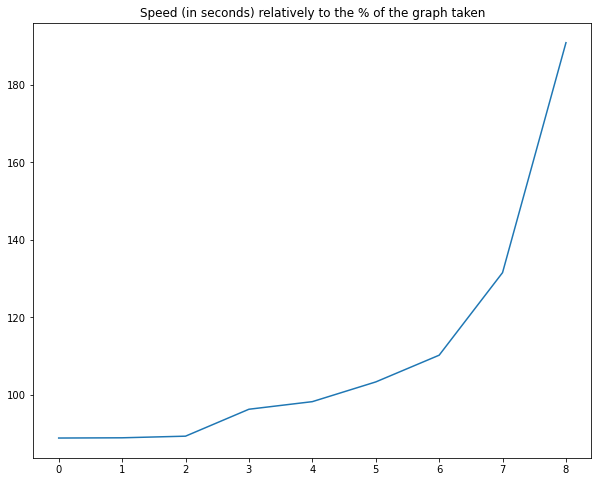

In [12]:
plt.figure(figsize=(10, 8))
plt.title("Speed (in seconds) relatively to the % of the graph taken")
plt.plot([time_[i][1] for i in range(len(time_))]);

## Try part, Dataframe

In [31]:
df = spark.read.format("csv").option("inferSchema", "true")\
                                        .option("delimiter", ',')\
                                        .option("header", 'true')\
                                        .load("web-Google_total.csv").toDF("val","key").cache()

In [32]:
df.show()

+------+------+
|   val|   key|
+------+------+
|     0|867923|
|     0|891835|
| 11342|     0|
| 11342| 27469|
| 11342| 38716|
| 11342|309564|
| 11342|322178|
| 11342|387543|
| 11342|427436|
| 11342|538214|
| 11342|638706|
| 11342|645018|
| 11342|835220|
| 11342|856657|
| 11342|867923|
| 11342|891835|
|824020|     0|
|824020| 91807|
|824020|322178|
|824020|387543|
+------+------+
only showing top 20 rows



In [33]:
import pyspark
from pyspark.sql import Window
from pyspark.sql.functions import *

def ccf_iterate_map_df(df):
    newRow = df.select("val", "key")
    df1 = df.union(newRow)
    return df1

def ccf_iterate_reduce_df(df1):
    window = Window.orderBy("key","val").partitionBy("key")
    df_min = df1.withColumn("min", min("val").over(window))

    new_column_1 = expr( """IF(min > key, Null, IF(min = val, key, val))""")
    new_column_2 = expr("""IF(min > key, Null, min)""")
    new_df = (df_min
      .withColumn("new_key", new_column_1)
      .withColumn("new_val", new_column_2)) \
    .na.drop() \
    .select(col("new_key").alias("key"), col("new_val").alias("val")) \
    .sort("val", "key") 
        
    df2 = new_df.distinct()
    
    return df2, df_min


import time

begin = time.time()
counter = 1
iteration = 0
while counter!=0:
    iteration +=1
    df1 = ccf_iterate_map_df(df)
    df1.cache()
    df.unpersist()
    df, df_counter = ccf_iterate_reduce_df(df1)
    df.cache()
    df1.unpersist()
    df_counter = df_counter.withColumn("counter_col", expr("""IF(min > key, 0, IF(min = val, 0, 1))"""))
    counter = df_counter.select(sum("counter_col")).collect()[0][0]
    print(counter)
    
end = time.time()

8275872
2772256
1919694
2879945
2146951
319984
8288
54
0


In [39]:
names = ["web-Google_500000.csv", "web-Google_1000000.csv", "web-Google_1500000.csv", "web-Google_2000000.csv", "web-Google_2500000.csv", "web-Google_3000000.csv", "web-Google_3500000.csv", "web-Google_4000000.csv", "web-Google_total.csv"]

liste = []
for i in names:
    df = spark.read.format("csv").option("inferSchema", "true")\
                                        .option("delimiter", ',')\
                                        .option("header", 'true')\
                                        .load(i).toDF("val","key").cache()
    begin = time.time()
    counter = 1
    iteration = 0
    while counter!=0:
        iteration +=1
        df1 = ccf_iterate_map_df(df)
        df1.cache()
        df.unpersist()
        df, df_counter = ccf_iterate_reduce_df(df1)
        df.cache()
        df1.unpersist()
        df_counter = df_counter.withColumn("counter_col", expr("""IF(min > key, 0, IF(min = val, 0, 1))"""))
        counter = df_counter.select(sum("counter_col")).collect()[0][0]
        print(counter)
    
    end = time.time()
    print((i, end-begin))
    liste.append((i, end-begin))

645720
188263
249888
326246
252536
73441
518
0
('web-Google_500000.csv', 476.46466517448425)
1379336
411275
466760
634325
483907
133761
1344
0
('web-Google_1000000.csv', 543.9730443954468)
2158798
651571
663595
916646
680213
154277
1966
0
('web-Google_1500000.csv', 571.6710729598999)
2965172
912104
846662
1189233
876542
174605
2038
0
('web-Google_2000000.csv', 583.3043549060822)
3789920
1184366
1023125
1451456
1057318
205858
2436
0
('web-Google_2500000.csv', 596.1450490951538)
4630528
1479228
1199555
1712234
1248788
214513
3162
0
('web-Google_3000000.csv', 632.7033257484436)
5483928
1785818
1373705
1981569
1446347
232332
4126
10
0
('web-Google_3500000.csv', 830.4311218261719)
6343536
2102129
1548923
2262060
1654681
257297
5834
22
0
('web-Google_4000000.csv', 929.0334510803223)
8275872
2772256
1919694
2879945
2146951


Py4JJavaError: An error occurred while calling o5281.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 43 in stage 967.0 failed 1 times, most recent failure: Lost task 43.0 in stage 967.0 (TID 205085) (hippolytes-macbook-pro.home executor driver): org.apache.spark.memory.SparkOutOfMemoryError: Unable to acquire 262144 bytes of memory, got 0
	at org.apache.spark.memory.MemoryConsumer.throwOom(MemoryConsumer.java:157)
	at org.apache.spark.memory.MemoryConsumer.allocateArray(MemoryConsumer.java:97)
	at org.apache.spark.unsafe.map.BytesToBytesMap.allocate(BytesToBytesMap.java:870)
	at org.apache.spark.unsafe.map.BytesToBytesMap.reset(BytesToBytesMap.java:974)
	at org.apache.spark.sql.execution.UnsafeKVExternalSorter.<init>(UnsafeKVExternalSorter.java:173)
	at org.apache.spark.sql.execution.UnsafeFixedWidthAggregationMap.destructAndCreateExternalSorter(UnsafeFixedWidthAggregationMap.java:248)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage124.agg_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage124.project_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage124.agg_doAggregateWithKeys_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage124.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:132)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2253)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2202)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2201)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2201)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1078)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2440)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2382)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2371)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2202)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2223)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2242)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2267)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1030)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1029)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:390)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:3519)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:3687)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$5(SQLExecution.scala:103)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:163)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:90)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:772)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:64)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:3685)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:3516)
	at sun.reflect.GeneratedMethodAccessor171.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.memory.SparkOutOfMemoryError: Unable to acquire 262144 bytes of memory, got 0
	at org.apache.spark.memory.MemoryConsumer.throwOom(MemoryConsumer.java:157)
	at org.apache.spark.memory.MemoryConsumer.allocateArray(MemoryConsumer.java:97)
	at org.apache.spark.unsafe.map.BytesToBytesMap.allocate(BytesToBytesMap.java:870)
	at org.apache.spark.unsafe.map.BytesToBytesMap.reset(BytesToBytesMap.java:974)
	at org.apache.spark.sql.execution.UnsafeKVExternalSorter.<init>(UnsafeKVExternalSorter.java:173)
	at org.apache.spark.sql.execution.UnsafeFixedWidthAggregationMap.destructAndCreateExternalSorter(UnsafeFixedWidthAggregationMap.java:248)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage124.agg_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage124.project_doConsume_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage124.agg_doAggregateWithKeys_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage124.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:755)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:132)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [21]:
df = sc.textFile("web-Google 2.txt").collect()

In [22]:
df = sc.parallelize(df)

In [23]:
df = df.map(lambda line: line.split('\t')) \
                    .filter(lambda line: len(line)>1) \
                        .map(lambda line: (line[0],line[1])).toDF()

In [29]:
import pyspark
from pyspark.sql import Window
from pyspark.sql.functions import *

df = sc.textFile("web-Google 2.txt").collect()
df = sc.parallelize(df)
df = df.map(lambda line: line.split('\t')) \
                    .filter(lambda line: len(line)>1) \
                        .map(lambda line: (line[0],line[1])).toDF()

def ccf_iterate_map_df(df):
    newRow = df.select("_1", "_2")
    df1 = df.union(newRow)
    return df1

def ccf_iterate_reduce_df(df1):
    window = Window.orderBy("_2","_1").partitionBy("_2")
    df_min = df1.withColumn("min", min("_1").over(window))

    new_column_1 = expr( """IF(min > _2, Null, IF(min = _1, _2, _1))""")
    new_column_2 = expr("""IF(min > _2, Null, min)""")
    new_df = (df_min
      .withColumn("new_key", new_column_1)
      .withColumn("new_val", new_column_2)) \
    .na.drop() \
    .select(col("new_key").alias("_2"), col("new_val").alias("_1")) \
    .sort("_1", "_2") 
        
    df2 = new_df.distinct()
    
    return df2, df_min


import time

begin = time.time()
counter_new_pair = sc.accumulator(1)
iteration = 0
while counter_new_pair!=0:
    counter_new_pair = sc.accumulator(0)
    iteration +=1
    df1 = ccf_iterate_map_df(df)
    df1.cache()
    df.unpersist()
    df, df_counter = ccf_iterate_reduce_df(df1)
    df.cache()
    df1.unpersist()
    df_counter = df_counter.withColumn("counter_col", expr("""IF(min > _2, 0, IF(min = _1, 0, 1))"""))
    counter_new_pair = sc.accumulator(df_counter.select(sum("counter_col")).collect()[0][0])
    print(counter)
    
end = time.time()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 205.0 failed 1 times, most recent failure: Lost task 1.0 in stage 205.0 (TID 30184) (hippolytes-macbook-pro.home executor driver): java.lang.OutOfMemoryError: GC overhead limit exceeded
	at org.apache.spark.rdd.HadoopRDD$$anon$1.getNext(HadoopRDD.scala:329)
	at org.apache.spark.rdd.HadoopRDD$$anon$1.getNext(HadoopRDD.scala:243)
	at org.apache.spark.util.NextIterator.hasNext(NextIterator.scala:73)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1429)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:315)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:313)
	at scala.collection.AbstractIterator.to(Iterator.scala:1429)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:307)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:307)
	at scala.collection.AbstractIterator.toBuffer(Iterator.scala:1429)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:294)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:288)
	at scala.collection.AbstractIterator.toArray(Iterator.scala:1429)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1030)
	at org.apache.spark.rdd.RDD$$Lambda$2071/1657378681.apply(Unknown Source)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2242)
	at org.apache.spark.SparkContext$$Lambda$2072/837736495.apply(Unknown Source)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.executor.Executor$TaskRunner$$Lambda$1318/1218837822.apply(Unknown Source)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2253)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2202)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2201)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2201)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1078)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1078)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2440)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2382)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2371)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2202)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2223)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2242)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2267)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1030)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1029)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:180)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.lang.OutOfMemoryError: GC overhead limit exceeded
	at org.apache.spark.rdd.HadoopRDD$$anon$1.getNext(HadoopRDD.scala:329)
	at org.apache.spark.rdd.HadoopRDD$$anon$1.getNext(HadoopRDD.scala:243)
	at org.apache.spark.util.NextIterator.hasNext(NextIterator.scala:73)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:458)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1429)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:315)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:313)
	at scala.collection.AbstractIterator.to(Iterator.scala:1429)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:307)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:307)
	at scala.collection.AbstractIterator.toBuffer(Iterator.scala:1429)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:294)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:288)
	at scala.collection.AbstractIterator.toArray(Iterator.scala:1429)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1030)
	at org.apache.spark.rdd.RDD$$Lambda$2071/1657378681.apply(Unknown Source)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2242)
	at org.apache.spark.SparkContext$$Lambda$2072/837736495.apply(Unknown Source)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.executor.Executor$TaskRunner$$Lambda$1318/1218837822.apply(Unknown Source)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)


----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 49858)
Traceback (most recent call last):
  File "/Users/hippolyteguigon/opt/anaconda3/lib/python3.8/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/Users/hippolyteguigon/opt/anaconda3/lib/python3.8/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/Users/hippolyteguigon/opt/anaconda3/lib/python3.8/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/Users/hippolyteguigon/opt/anaconda3/lib/python3.8/socketserver.py", line 720, in __init__
    self.handle()
  File "/Users/hippolyteguigon/opt/anaconda3/lib/python3.8/site-packages/pyspark/accumulators.py", line 262, in handle
    poll(accum_updates)
  File "/Users/hippolyteguigon/opt/anaconda3/lib/python3.8/site-packages/pyspark/accumulators.py", line 23

In [26]:
print(end-begin)

861.835107088089


In [50]:
import pyspark
from pyspark.sql import Window
from pyspark.sql.functions import *

def ccf_iterate_map_df(df):
    newRow = df.select("_1", "_2")
    df1 = df.union(newRow)
    return df1

def ccf_iterate_reduce_df(df1):
    window = Window.orderBy("_2","_1").partitionBy("_2")
    df_min = df1.withColumn("min", min("_2").over(window))

    new_column_1 = expr( """IF(min > _2, Null, IF(min = _1, _2, _1))""")
    new_column_2 = expr("""IF(min > _2, Null, min)""")
    new_df = (df_min
      .withColumn("new_key", new_column_1)
      .withColumn("new_val", new_column_2)) \
    .na.drop() \
    .select(col("new_key").alias("_2"), col("new_val").alias("_1")) \
    .sort("_1", "_2") 
        
    df2 = new_df.distinct()
    
    return df2, df_min


import time

begin = time.time()
counter = 1
iteration = 0
while counter!=0:
    iteration +=1
    df1 = ccf_iterate_map_df(df)
    df1.cache()
    df.unpersist()
    df, df_counter = ccf_iterate_reduce_df(df1)
    df.cache()
    df1.unpersist()
    df_counter = df_counter.withColumn("counter_col", expr("""IF(min > key, 0, IF(min = val, 0, 1))"""))
    counter = df_counter.select(sum("counter_col")).collect()[0][0]
    print(counter)
    
end = time.time()

AnalysisException: cannot resolve '`key`' given input columns: [_1, _2, min]; line 1 pos 9;
'Project [_1#220960, _2#220961, min#221000, 'IF((min#221000 > 'key), 0, 'IF((min#221000 = 'val), 0, 1)) AS counter_col#221074]
+- Project [_1#220960, _2#220961, min#221000]
   +- Project [_1#220960, _2#220961, min#221000, min#221000]
      +- Window [min(_2#220961) windowspecdefinition(_2#220961, _2#220961 ASC NULLS FIRST, _1#220960 ASC NULLS FIRST, specifiedwindowframe(RangeFrame, unboundedpreceding$(), currentrow$())) AS min#221000], [_2#220961], [_2#220961 ASC NULLS FIRST, _1#220960 ASC NULLS FIRST]
         +- Project [_1#220960, _2#220961]
            +- Union false, false
               :- LogicalRDD [_1#220960, _2#220961], false
               +- Project [_1#220960 AS _1#220975, _2#220961 AS _2#220976]
                  +- Project [_1#220960, _2#220961]
                     +- LogicalRDD [_1#220960, _2#220961], false


In [ ]:
reverseDF = df.select(col("From").alias("To"),col("To").alias("From"))# getting all (v,k)
    df_0 = df.union(reverseDF)# Building a new DataFrame containing all (k,v) and (v,k)
    
    # Grouping by key on the first element (k, [v1, v2...])
    df_1 = df_0.groupBy(col("To")).agg(f.array_distinct(collect_list(col("From"))).alias('From'))
    
    # New k: the minimum between k and all elements included in v 
    # New v: all values from k and v
    df_2 = df_1.withColumn('From', array_union(df_1.From, array(df_1.To))).withColumn('To', array_min("From"))
    
    # Extracting each element of v as our key k and assigning it the corresponding minimum found above
    df_3 = df_2.select( explode(col("From")).alias("To"), col("To").alias("From")).dropDuplicates()

In [27]:
df.show()

+------+------+
|    To|  From|
+------+------+
|     0|867923|
|     0|891835|
| 11342|     0|
| 11342| 27469|
| 11342| 38716|
| 11342|309564|
| 11342|322178|
| 11342|387543|
| 11342|427436|
| 11342|538214|
| 11342|638706|
| 11342|645018|
| 11342|835220|
| 11342|856657|
| 11342|867923|
| 11342|891835|
|824020|     0|
|824020| 91807|
|824020|322178|
|824020|387543|
+------+------+
only showing top 20 rows



## Analysis of Dataframes

In [35]:
#First, let's define our function to import and analyze Dataframes

def our_union (x):
    x[1].append(x[0])
    return x[1]

our_union_udf = f.udf(our_union, ArrayType(IntegerType()))
findmin = f.udf(lambda x: min(x), IntegerType())
our_distinct = f.udf(lambda x: list(set(x)), ArrayType(IntegerType()))

def CCF_DEDUP_df(df):
    
    reverseDF = df.select(col("From").alias("To"),col("To").alias("From"))
    df_0 = df.union(reverseDF)
    
    df_1 = df_0.groupBy(col("To")).agg(our_distinct(collect_list(col("From"))).alias('From'))
    df_2 = df_1.withColumn('From', our_union_udf(struct(df_1.To, df_1.From)))\
                    .withColumn('To', findmin("From"))\
                        .withColumn('From', our_distinct('From'))
    
    df_3 = df_2.select( explode(col("From")).alias("To"), col("To").alias("From")).dropDuplicates()
    
    return df_3

def Analyze(df):
    
    reverseDF = df.select(col("From").alias("To"),col("To").alias("From"))
    df_0 = df.union(reverseDF)
      
    size = df_0.distinct().count()/2

    t = time.time()
    
    counter = 0 
    while df.count()!= df.select('To').distinct().count() :
        counter +=1 
        df = CCF_DEDUP_df(df) 
    t = time.time() - t
    
    #Getting the number of groups of connected components
    num_of_groups = len(df.select('From').distinct().collect())
    
    return t, size,num_of_groups, counter,  df

In [37]:
Analyze("web-Google_total.csv")

AttributeError: 'str' object has no attribute 'select'

In [28]:
df_test1 = pd.read_csv("web-Google 2.txt", sep="\t").head(5000000000000000)

In [29]:
df_test1.to_csv("web-Google_test.csv", header=False, index=False)

In [25]:
names = ["web-Google_500000.csv", "web-Google_1000000.csv", "web-Google_1500000.csv", "web-Google_2000000.csv", "web-Google_2500000.csv", "web-Google_3000000.csv", "web-Google_3500000.csv", "web-Google_4000000.csv", "web-Google_1000000.csv"]

time_df = []

for file in names:
    df = spark.read.format("csv").option("inferSchema", "true")\
                                        .option("delimiter", ',')\
                                        .option("header", 'true')\
                                        .load(file).toDF("To","From").cache()
    
    time_df.append(Analyze(df)[0])
    


NameError: name 'Analyze' is not defined

In [15]:
time_df = [742.6663370132446,
 1173.5141010284424,
 1178.273682832718,
 1244.8001997470856,
 2275.856563806534,
 1476.6470799446106,
 1604.9051089286804,
 1770.9568598270416,
 1165.5193858146667]

## RDD vs Dataframe

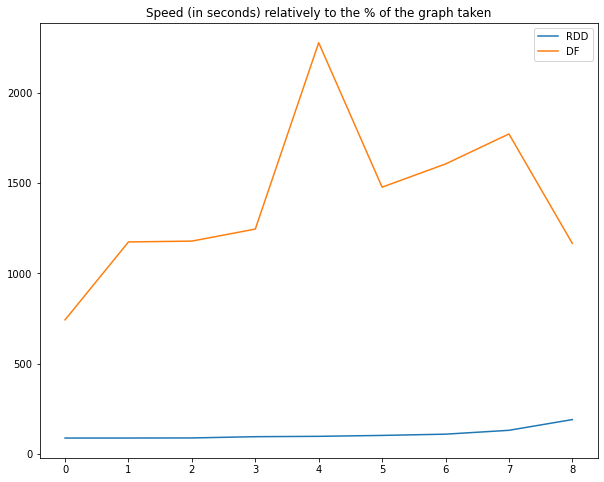

In [22]:
plt.figure(figsize=(10, 8))
plt.title("Speed (in seconds) relatively to the % of the graph taken")
plt.plot([time_[i][1] for i in range(len(time_))], label="RDD")
plt.plot([time_df[i] for i in range(len(time_df))], label="DF")
plt.legend()
plt.show();

In [46]:
df = spark.read.format("csv").option("inferSchema", "true")\
                                        .option("delimiter", ',')\
                                        .option("header", 'true')\
                                        .load("web-Google 2.txt.csv").toDF("To","From").cache()

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:50245)
Traceback (most recent call last):
  File "/Users/hippolyteguigon/opt/anaconda3/lib/python3.8/site-packages/py4j/java_gateway.py", line 977, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/hippolyteguigon/opt/anaconda3/lib/python3.8/site-packages/py4j/java_gateway.py", line 1115, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 61] Connection refused


Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:50245)

In [33]:
df.count()

499999

In [51]:
names = ["web-Google_500000.csv", "web-Google_1000000.csv", "web-Google_1500000.csv", "web-Google_2000000.csv", "web-Google_2500000.csv", "web-Google_3000000.csv", "web-Google_3500000.csv", "web-Google_4000000.csv", "web-Google_total.csv"]

computation = pd.DataFrame(columns=names)

time1 = time.time()

computation.loc["Number of elements"] = [spark.read.format("csv").option("inferSchema", "true")\
                                        .option("delimiter", ',')\
                                        .option("header", 'true')\
                                        .load(i).toDF("To","From").cache().count() + 1 for i in names]

computation.loc["Number of connected components"] = [Analyze(spark.read.format("csv").option("inferSchema", "true")\
                                        .option("delimiter", ',')\
                                        .option("header", 'true')\
                                        .load(i).toDF("To","From").cache())[2] for i in names]

computation.loc["Computation time"] = [Analyze(spark.read.format("csv").option("inferSchema", "true")\
                                        .option("delimiter", ',')\
                                        .option("header", 'true')\
                                        .load(i).toDF("To","From").cache())[3] for i in names]

time2 = time.time()

print("It took {:.2f} seconds for this operation".format(time2-time1))

KeyboardInterrupt: 

In [64]:
import pyspark
from pyspark.sql import Window
from pyspark.sql.functions import *

def ccf_iterate_map_df(df):
    newRow = df.select("val", "key")
    df1 = df.union(newRow)
    return df1

def ccf_iterate_reduce_df(df1):
    window = Window.orderBy("key","val").partitionBy("key")
    df_min = df1.withColumn("min", min("val").over(window))

    new_column_1 = expr( """IF(min > key, Null, IF(min = val, key, val))""")
    new_column_2 = expr("""IF(min > key, Null, min)""")
    new_df = (df_min
      .withColumn("new_key", new_column_1)
      .withColumn("new_val", new_column_2)) \
    .na.drop() \
    .select(col("new_key").alias("key"), col("new_val").alias("val")) \
    .sort("val", "key") 
        
    df2 = new_df.distinct()
    
    return df2, df_min


import time

begin = time.time()
counter = 1
iteration = 0
while counter!=0:
    iteration +=1
    df1 = ccf_iterate_map_df(df)
    df1.cache()
    df.unpersist()
    df, df_counter = ccf_iterate_reduce_df(df1)
    df.cache()
    df1.unpersist()
    df_counter = df_counter.withColumn("counter_col", expr("""IF(min > key, 0, IF(min = val, 0, 1))"""))
    counter = df_counter.select(sum("counter_col")).collect()[0][0]
    print(counter)
    
end = time.time()

AnalysisException: cannot resolve '`val`' given input columns: [From, To];
'Project [To#175938, From#175939, min('val) windowspecdefinition('key, 'key ASC NULLS FIRST, 'val ASC NULLS FIRST, unspecifiedframe$()) AS min#175978]
+- Union false, false
   :- Project [cast(_1#175934 as int) AS To#175938, cast(_2#175935 as int) AS From#175939]
   :  +- LogicalRDD [_1#175934, _2#175935], false
   +- Project [To#175938 AS To#175953, From#175939 AS From#175954]
      +- Project [To#175938, From#175939]
         +- Project [cast(_1#175934 as int) AS To#175938, cast(_2#175935 as int) AS From#175939]
            +- LogicalRDD [_1#175934, _2#175935], false


In [39]:
graph = sc.parallelize(web_google.collect()[1:len(web_google.collect())])
graph = graph.toDF()

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:50245)
Traceback (most recent call last):
  File "/Users/hippolyteguigon/opt/anaconda3/lib/python3.8/site-packages/py4j/java_gateway.py", line 977, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/hippolyteguigon/opt/anaconda3/lib/python3.8/site-packages/py4j/java_gateway.py", line 1115, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 61] Connection refused


Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:50245)

In [34]:
graph.show()

AttributeError: can't set attribute

In [25]:
def our_union (x):
    x[1].append(x[0])
    return x[1]

our_union_udf = f.udf(our_union, ArrayType(IntegerType()))
findmin = f.udf(lambda x: min(x), IntegerType())
our_distinct = f.udf(lambda x: list(set(x)), ArrayType(IntegerType()))

def CCF_DEDUP_df(df):
    
    reverseDF = df.select(col("From").alias("To"),col("To").alias("From"))
    df_0 = df.union(reverseDF)
    
    df_1 = df_0.groupBy(col("To")).agg(our_distinct(collect_list(col("From"))).alias('From'))
    df_2 = df_1.withColumn('From', our_union_udf(struct(df_1.To, df_1.From)))\
                    .withColumn('To', findmin("From"))\
                        .withColumn('From', our_distinct('From'))
    
    df_3 = df_2.select( explode(col("From")).alias("To"), col("To").alias("From")).dropDuplicates()
    
    return df_3

def Analyze(df):
    
    reverseDF = df.select(col("From").alias("To"),col("To").alias("From"))
    df_0 = df.union(reverseDF)
      
    size = df_0.distinct().count()/2

    t = time.time()
    
    counter = sc.accumulator(1)
    while df.count()!= df.select('To').distinct().count() :
        counter_new_pair.add(1)
        df = CCF_DEDUP_df(df) 
    t = time.time() - t
    
    #Getting the number of groups of connected components
    num_of_groups = len(df.select('From').distinct().collect())
    
    return t, size,num_of_groups, counter,  df

In [27]:
import pyspark
from pyspark.sql import Window
from pyspark.sql.functions import *

def ccf_iterate_map_df(df):
    newRow = df.select("val", "key")
    df1 = df.union(newRow)
    return df1

def ccf_iterate_reduce_df(df1):
    window = Window.orderBy("key","val").partitionBy("key")
    df_min = df1.withColumn("min", min("val").over(window))

    new_column_1 = expr( """IF(min > key, Null, IF(min = val, key, val))""")
    new_column_2 = expr("""IF(min > key, Null, min)""")
    new_df = (df_min
      .withColumn("new_key", new_column_1)
      .withColumn("new_val", new_column_2)) \
    .na.drop() \
    .select(col("new_key").alias("key"), col("new_val").alias("val")) \
    .sort("val", "key") 
        
    df2 = new_df.distinct()
    
    return df2, df_min


import time

begin = time.time()
counter = 1
iteration = 0
while counter!=0:
    iteration +=1
    df1 = ccf_iterate_map_df(df)
    df1.cache()
    df.unpersist()
    df, df_counter = ccf_iterate_reduce_df(df1)
    df.cache()
    df1.unpersist()
    df_counter = df_counter.withColumn("counter_col", expr("""IF(min > key, 0, IF(min = val, 0, 1))"""))
    counter = df_counter.select(sum("counter_col")).collect()[0][0]
    print(counter)
    
end = time.time()

AnalysisException: cannot resolve '`key`' given input columns: [From, To, min]; line 1 pos 9;
'Project [To#521, From#522, min#663, 'IF((min#663 > 'key), null, 'IF((min#663 = 'val), 'key, 'val)) AS new_key#667]
+- Project [To#521, From#522, min#663]
   +- Project [To#521, From#522, min#663, min#663]
      +- Window [min(From#522) windowspecdefinition(To#521, To#521 ASC NULLS FIRST, From#522 ASC NULLS FIRST, specifiedwindowframe(RangeFrame, unboundedpreceding$(), currentrow$())) AS min#663], [To#521], [To#521 ASC NULLS FIRST, From#522 ASC NULLS FIRST]
         +- Project [To#521, From#522]
            +- Union false, false
               :- Project [0#517 AS To#521, 824020#518 AS From#522]
               :  +- Relation[0#517,824020#518] csv
               +- Project [From#522 AS From#578, To#521 AS To#579]
                  +- Project [From#522, To#521]
                     +- Project [0#517 AS To#521, 824020#518 AS From#522]
                        +- Relation[0#517,824020#518] csv
